# Algebraic Topological Data Analysis on rs-fMRI data to investigate free energy dynamics
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Introduction**
In this notebook, we compute the Euler characteristic and Betti numbers from simplicial complexes representing functional neural networks. The networks are constructed using rs-fMRI (resting-state functional magnetic resonance imaging) data. After computing these TDA metrics, we attempt to calculate the free energy of these networks.

## Importing data

**Import libraries**

In [1]:
# Basic data manipulation and visualisation libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Possibility to stop warnings
import warnings
warnings.filterwarnings('ignore') 

**Import data**

Generate an average connectivity matrix from the whole human connectome dataset.

In [2]:
# Importing all matrices to generate averaged data with Numpy or Pandas
matrices = [np.genfromtxt(file) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]
matricesP = [pd.read_csv(file, header = None, delim_whitespace=True) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]

# Averaging matrices with Numpy
MatAv = np.zeros(shape=matrices[0].shape)
for matrix in matrices:
    MatAv += matrix

matrix = MatAv/len(matrices)

# Averaging matrices with Pandas
Pdmatrix = pd.concat(matricesP).groupby(level=0).mean()

Obtain region names and subnetwork information

In [3]:
# Obtaining name of areas according to matching file
lineList = [line.rstrip('\n') for line in open('./1000_Functional_Connectomes/Region Names/Baltimore_5560_region_names_abbrev_file.txt')]

# Obtaining a random list of numbers to simulate subnetworks -- THESE NUMBERS DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
sublist = [line.rstrip('\n') for line in open('./subnet_ordernames.txt')]

# Obtaining a random list of colors that will match the random subnetwork classification for further graphs -- THESE COLORNAMES DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
colorlist = [line.rstrip('\n') for line in open('./subnet_order_colors.txt')]

# Obtaining a random list of colors (in numbers) that will match the random subnetwork classification for further graphs -- THESE NUMBERS DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
colornumbs = np.genfromtxt('./subnet_colors_number.txt')

Plot heatmap of the correlation matrix.

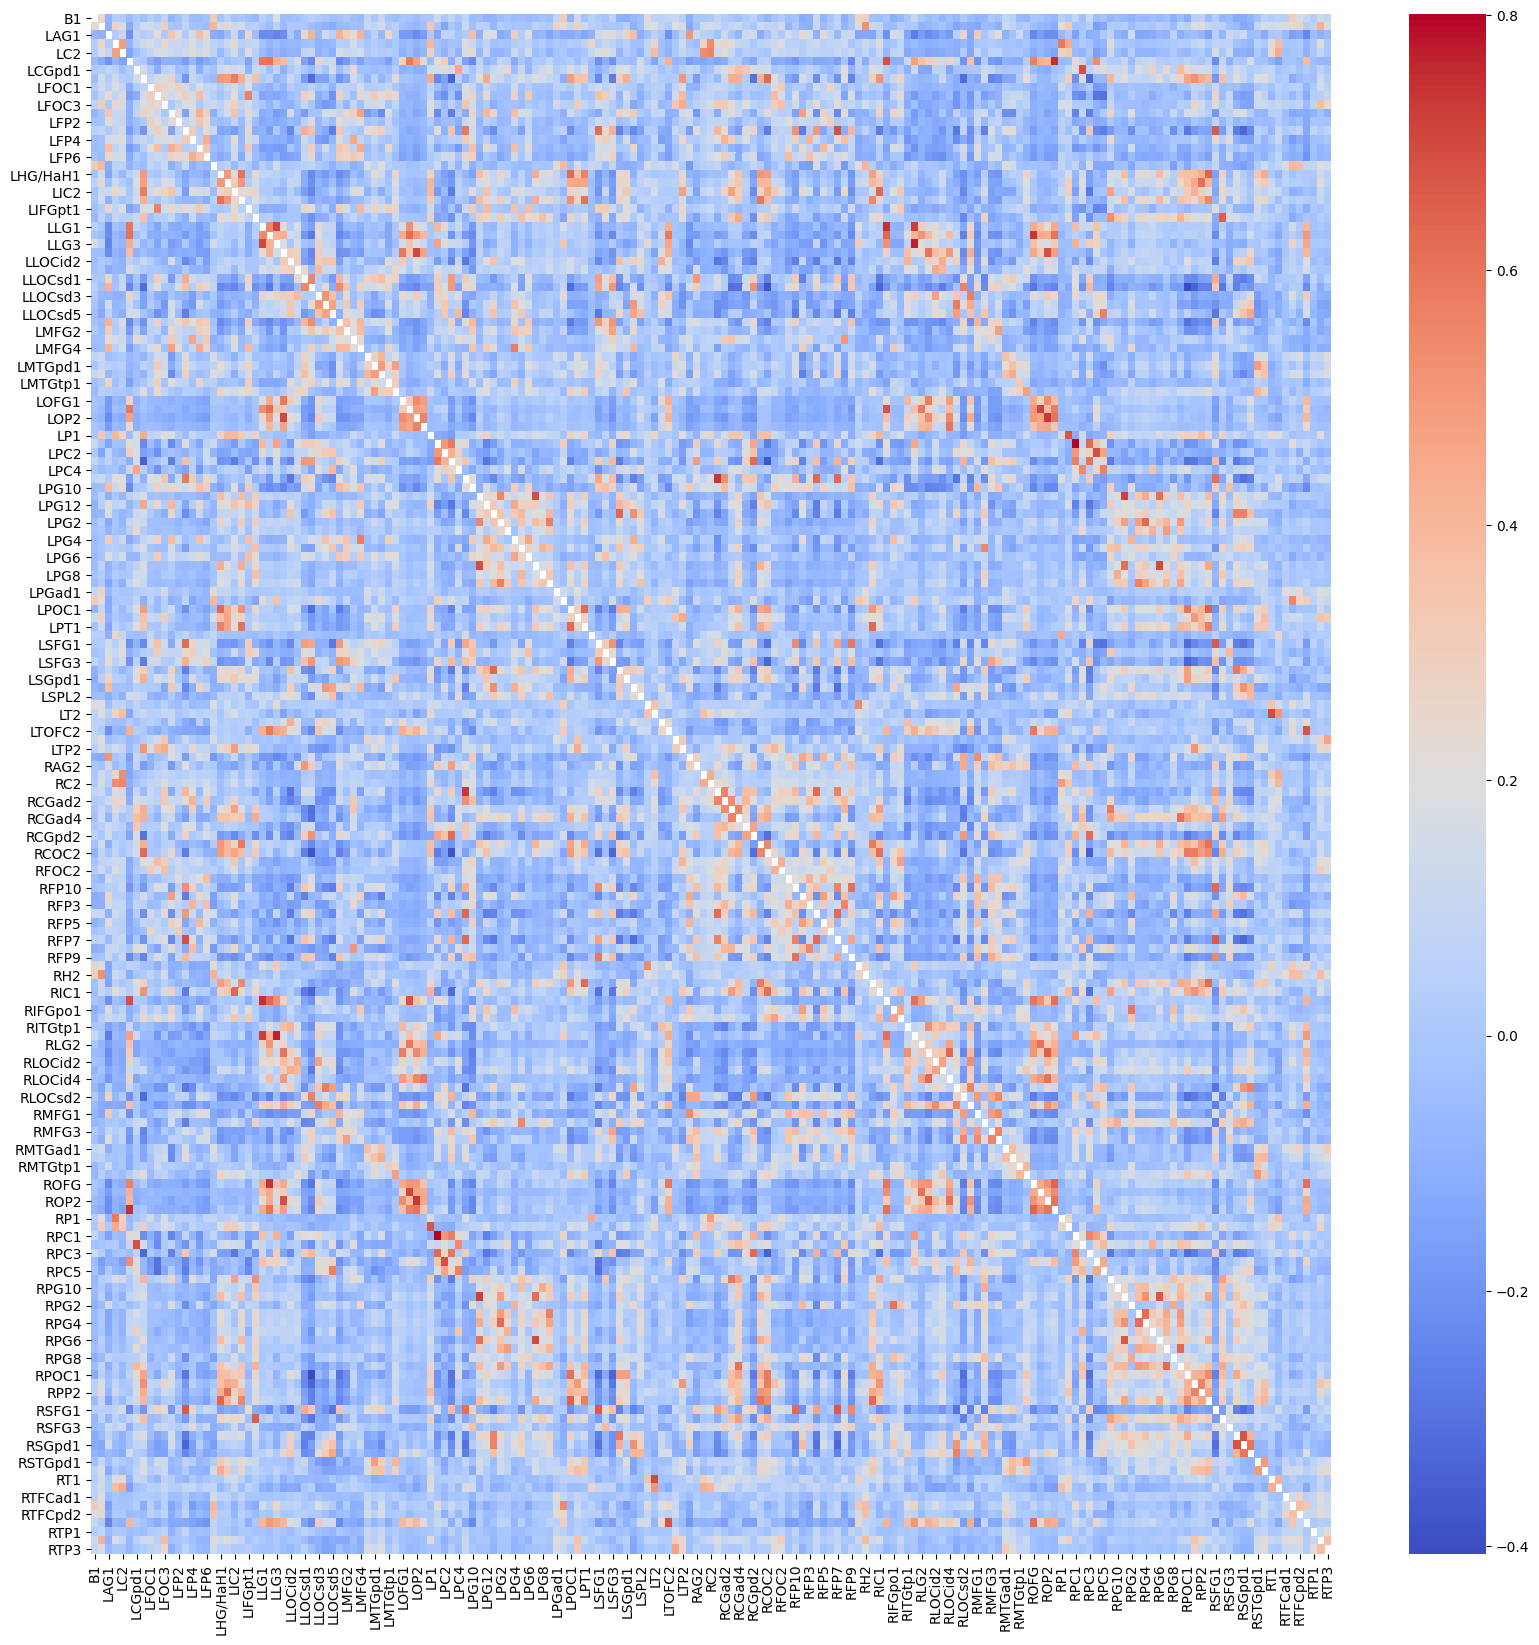

In [6]:
# Creating a DataFrame which will have the rows and column names according to the brain areas
matrixdiagNaN = matrix.copy()
np.fill_diagonal(matrixdiagNaN,np.nan)
Pdmatrix = pd.DataFrame(matrixdiagNaN)
Pdmatrix.columns = lineList
Pdmatrix.index = lineList
Pdmatrix = Pdmatrix.sort_index(0).sort_index(1)

# This mask variable gives you the possibility to plot only half of the correlation matrix. 
mask = np.zeros_like(Pdmatrix.values, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

plt.figure(figsize = (20, 20))
_ = sns.heatmap(Pdmatrix, cmap='coolwarm', cbar=True, square=False, mask=None) # To apply the mask, change to mask=mask

## Compute graph metrics

First, absolutise the weighted matrix, so potential biological information from negative correlation is maintained.

In [7]:
# Absolutise for further user
matrix = abs(matrix)
matrixdiagNaN = abs(matrixdiagNaN)

Create a graph from the matrix and remove any self-loops

In [12]:
# Creating a graph
G = nx.from_numpy_matrix(matrix)

# Removing self-loops
G.remove_edges_from(list(nx.selfloop_edges(G)))

## Visualisation of the network

First, let's get some important attributes about brain area names and subnetworks. These will be used later for graphical visualisation!

In [17]:
# Function to transform our list of brain areas into a dictionary
def Convert(lst): 
    res_dct = {i : lst[i] for i in range(0, len(lst))} 
    return res_dct

# Add brain areas as attribute of nodes
nx.set_node_attributes(G, Convert(lineList), 'area')

# Add node colors
nx.set_node_attributes(G, Convert(colorlist), 'color')

# Add subnetwork attribute
nx.set_node_attributes(G, Convert(sublist), 'subnet')

# Add node color numbers
nx.set_node_attributes(G, Convert(colornumbs), 'colornumb')

Now we will create a standard spring network plot, but this could also be made circular by changing to *draw_circular*.

We defined the edge widths to the power of 2 so that weak weights will have smaller widths.

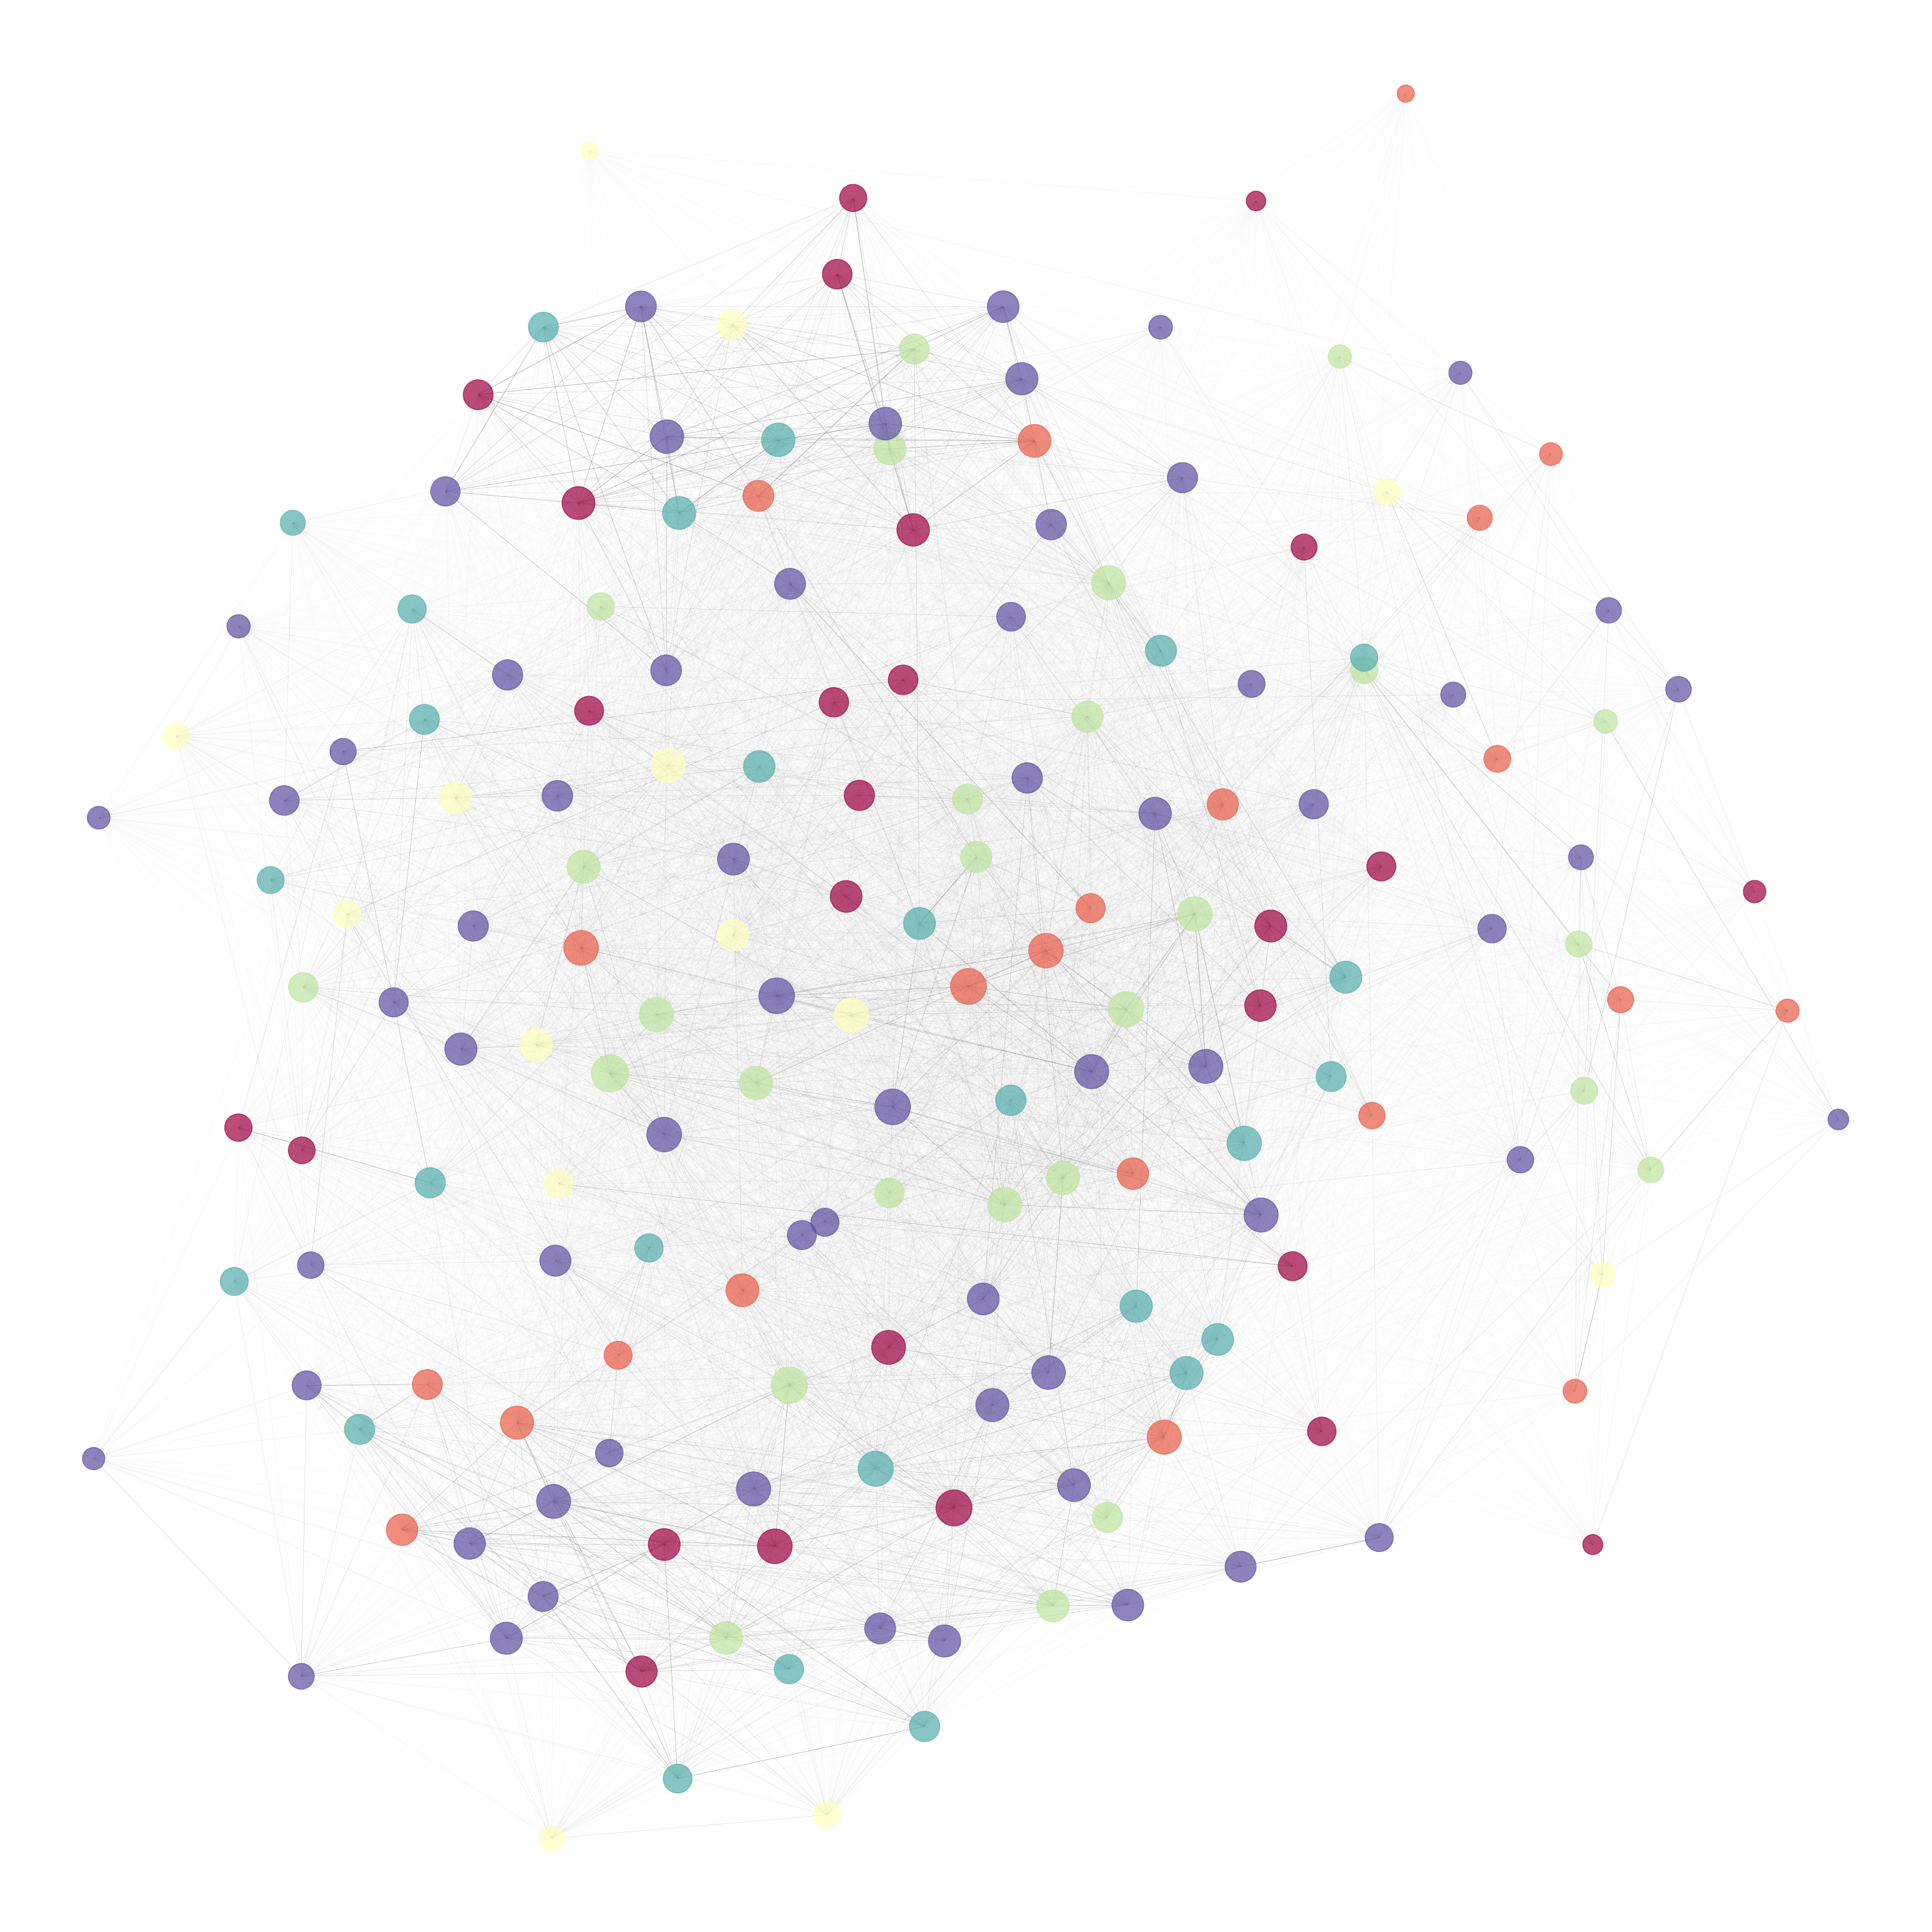

In [82]:
# Standard Network graph with nodes in proportion to Graph degrees
plt.figure(figsize=(30,30))
edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]
pos = nx.spring_layout(G, scale=5)
nx.draw(G, pos, with_labels=False, width=np.power(edgewidth, 2), edge_color='grey', node_size=normstrengthlist*10000, 
        labels=Convert(lineList), font_color='black', node_color=colornumbs/10, cmap=plt.cm.Spectral, alpha=0.7, font_size=9)
#plt.savefig('network.jpeg')

For the sake of a less overwhelming plot, we will work with the st50G graph for the CircosPlot.

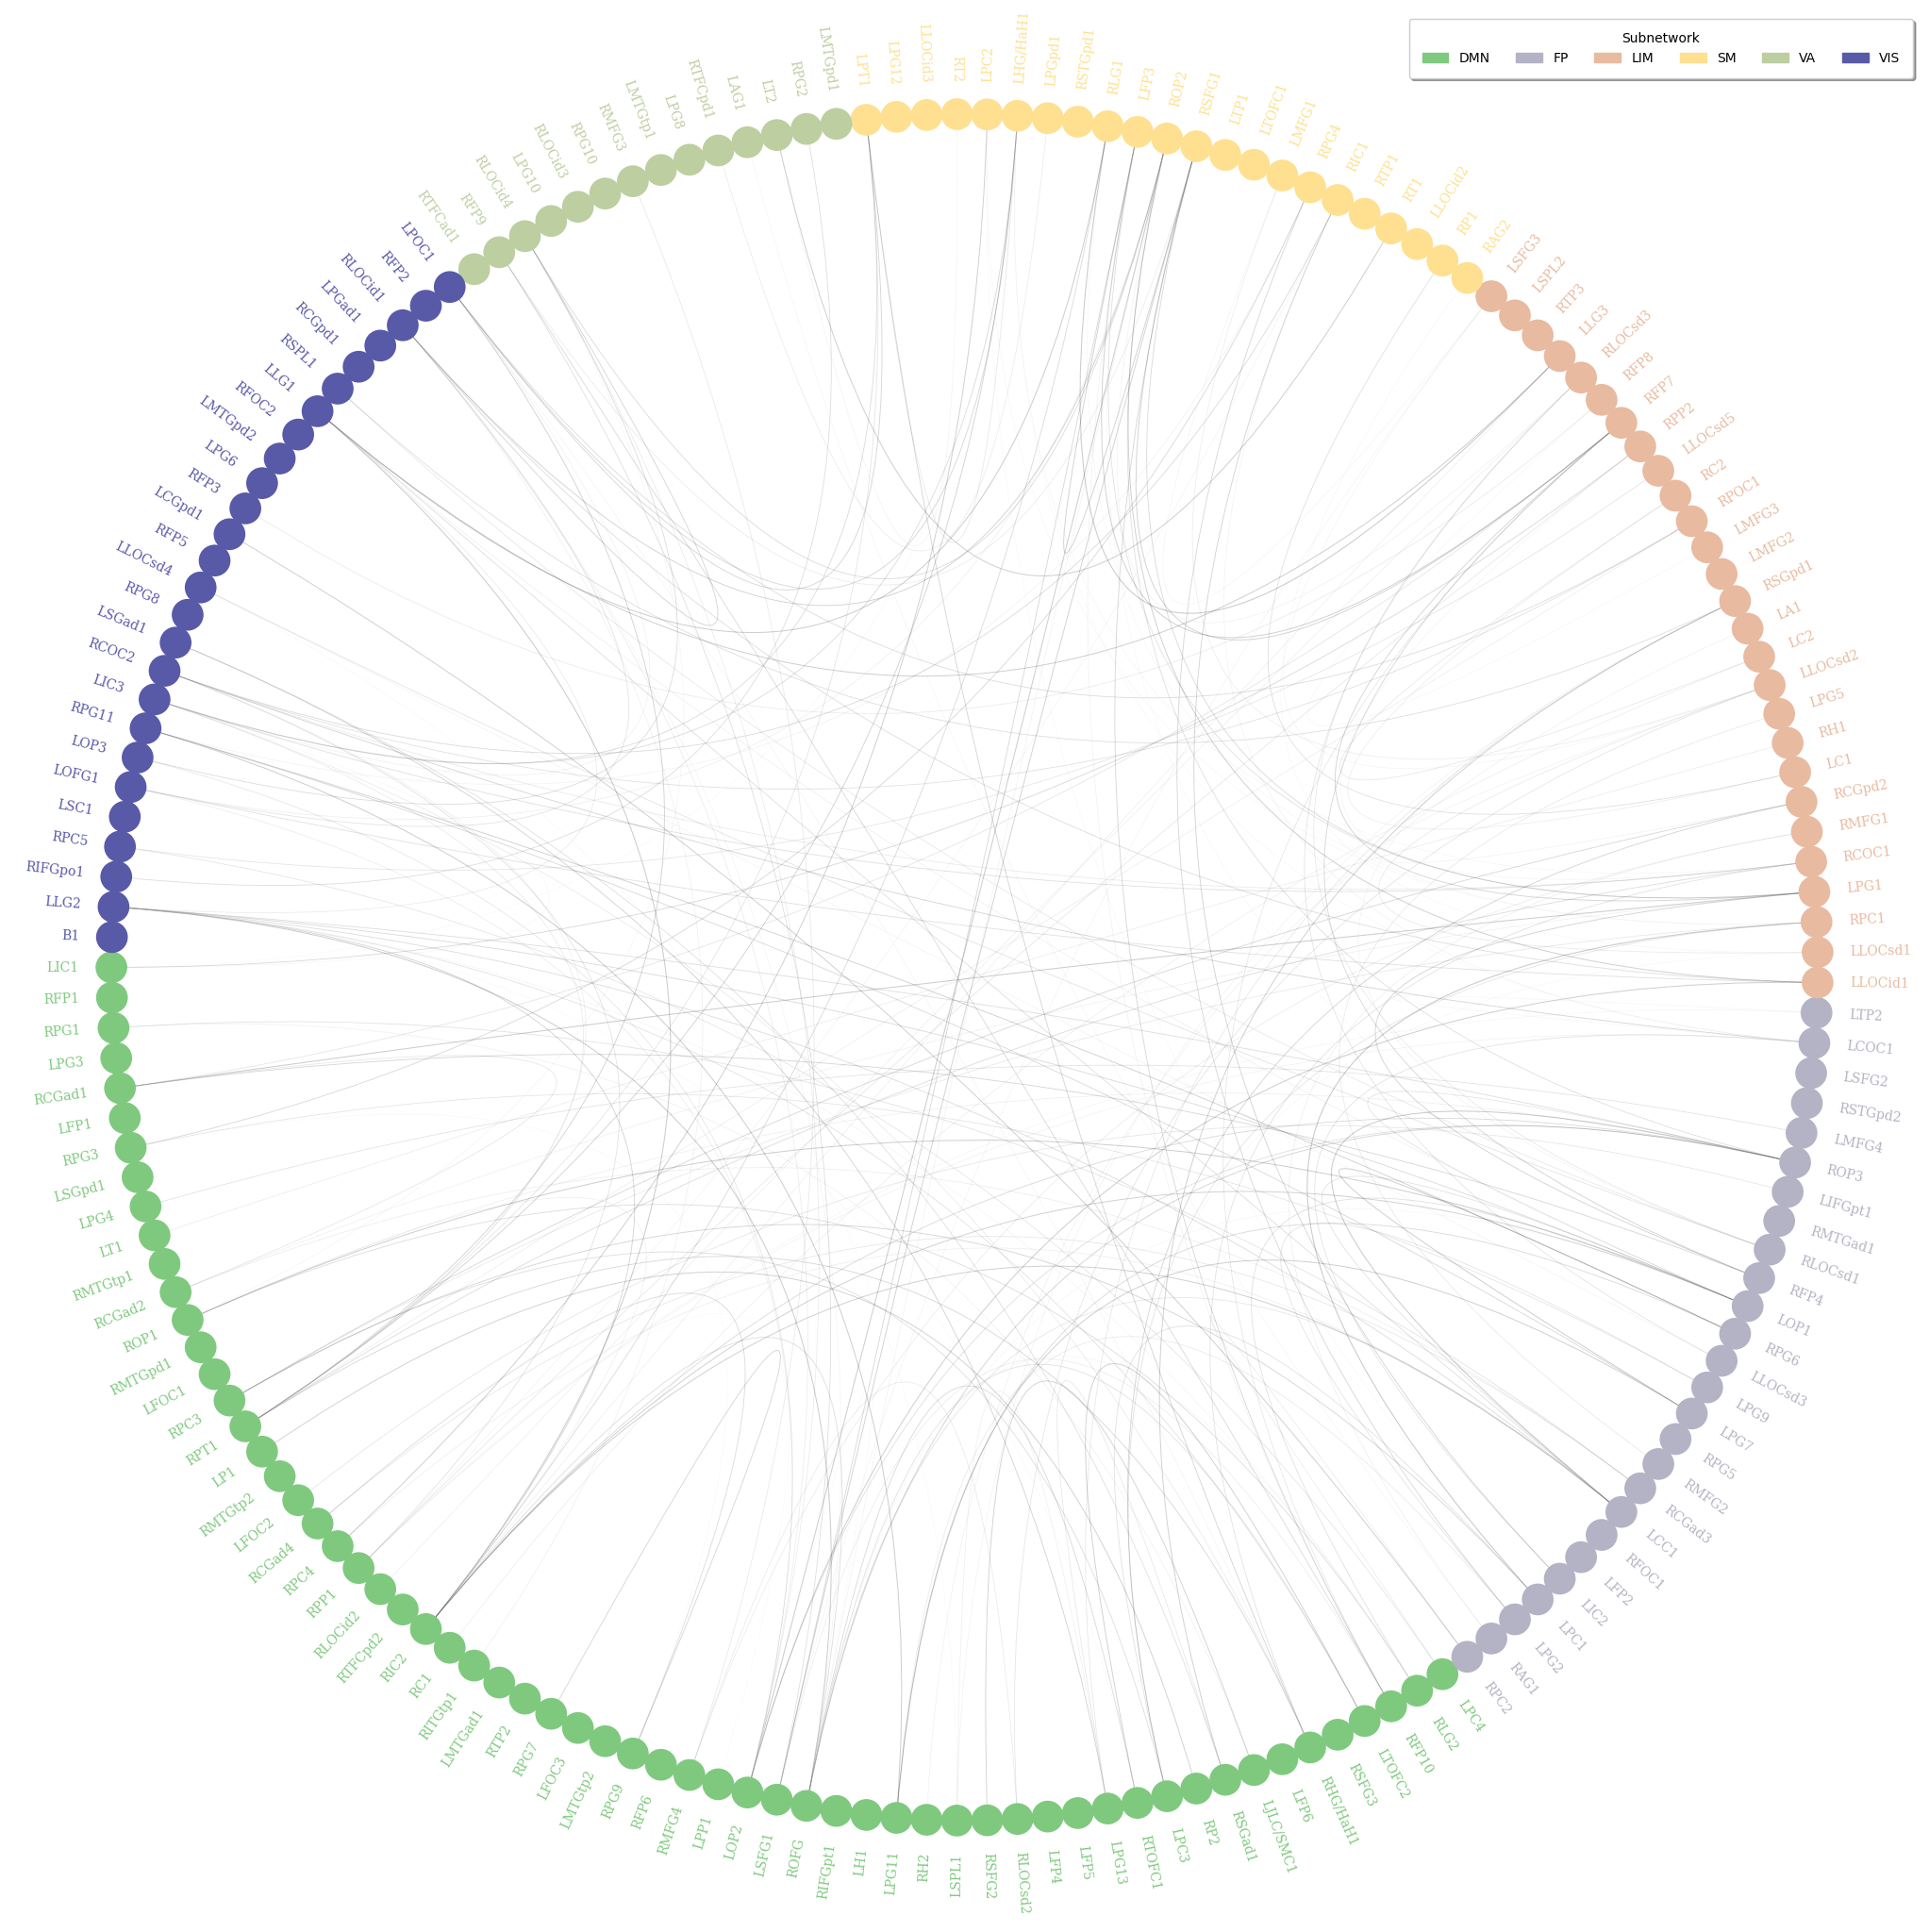

In [19]:
# First let's just add some attributes so that it becomes more interesting

nx.set_node_attributes(st50G, dict(st50G.degree(weight='weight')), 'strength')

nx.set_node_attributes(st50G, Convert(lineList), 'area')

nx.set_node_attributes(st50G, Convert(colorlist), 'color')

nx.set_node_attributes(st50G, Convert(sublist), 'subnet')

#edgecolors = {(e1, e2): int((weight+1)**3) for e1, e2, weight in st50G.edges(data='weight')}

# Then add them as attributes to the graph
#nx.set_edge_attributes(st50G, edgecolors, 'edgecolor')

G_distance_dict2 = {(e1, e2): 1 / abs(weight) for e1, e2, weight in st50G.edges(data='weight')}

# Then add them as attributes to the graph
nx.set_edge_attributes(st50G, G_distance_dict2, 'distance')


st50GRL = nx.relabel_nodes(st50G, {i: lineList[i] for i in range(len(lineList))})

# CircosPlot
circ = CircosPlot(st50GRL, figsize=(30,30), node_labels=True, node_label_layout='rotation', node_order='subnet',
                  edge_color='weight', edge_width='weight', node_color='subnet', node_label_color=True, fontsize=10, 
                  nodeprops={"radius": 2}, group_legend=True, group_label_offset=5)

circ.draw()

circ.sm.colorbar.remove()
labels_networks = sorted(list(set([list(circ.graph.nodes.values())[n][circ.node_color] for n in np.arange(len(circ.nodes))])))

plt.legend(handles=circ.legend_handles,
           title="Subnetwork",
           ncol=6,
           borderpad=1,
           shadow=True,
           fancybox=True,
           loc='best',
           fontsize=10,
           labels= labels_networks)

plt.show()

## Topology and Geometry of the network

**Betti numbers**

A set of topological invariants are the Betti numbers (𝛽). Given that a simplicial complex is a high-dimensional structure, 𝛽𝑘 counts the number of k-dimensional holes in the simplicial complex. These are topological invariants that cor-respond, for each 𝑘≥0, to the number of linearly independent k-dimensional holes in the simplicial complex.

In [86]:
# Import TDA functions
%run "./Background Scripts/TDA.py"

# Compute a sparser graph (10%)
G_d10 = densthr(0.1, matrix)

# Compute Betti number
Betti_k(G_d10, 1)

21

In [89]:
Betti_list = []

for i in np.arange(0.1,0.3,0.2):
    G = densthr(i, matrix)
    Betti_number = Betti_k(G, 1)
    Betti_list.append(Betti_number)

print(Betti_list)

KeyboardInterrupt: 

**Euler Characteristic**

Another topological invariant is the Euler characteristic. From this value we can compute the Euler entropy of the network.

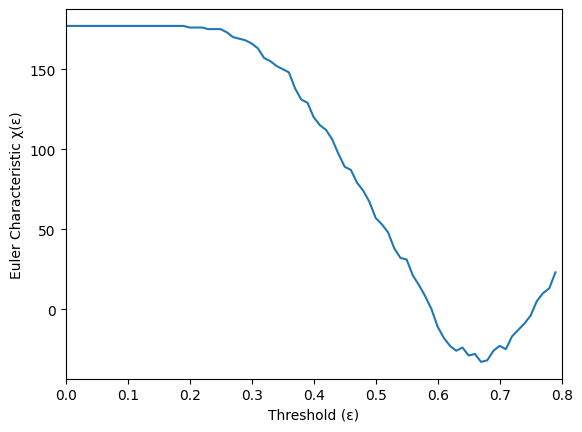

In [77]:
# Plot the Euler characteristic for a given threshold interval
i = matrix
maxvalue = 80
plt.plot(Eulerchoice_thr(i,maxvalue,0))
plt.xlabel('Threshold (ε)')
plt.ylabel('Euler Characteristic χ(ε)')
locs, labels = plt.xticks()
plt.xticks(locs, list(locs/100))
plt.xlim(0, maxvalue)
plt.show()

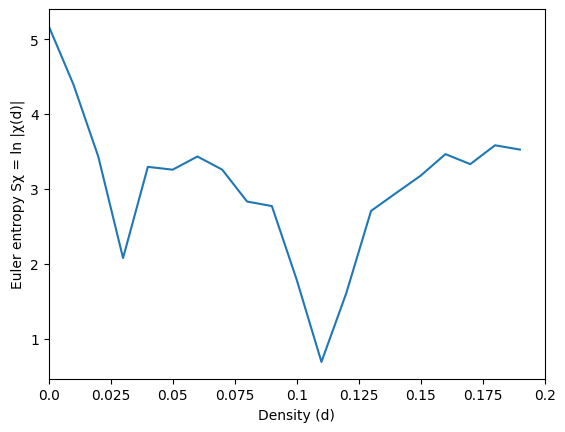

In [78]:
# Euler entropy (Sχ = ln|χ|) as a function of the correlation density level.
plotEuler_den(matrix, 20)